[ 0.   0.5  1.   2.   4.   8.  16.  32. ]
[41.46333333 36.48333333 32.18333333 25.64333333 16.24833333  7.31
  3.035       1.875     ]
[9.405      9.24666667 9.12833333 8.64       8.18166667 7.21
 5.305      2.93166667]
[0.26287936 0.24658783 0.23160071 0.20673386 0.16456171 0.11037814
 0.07112196 0.0559017 ]
[0.12519984 0.1241415  0.12334459 0.12       0.11677376 0.10962056
 0.09403014 0.06990072]

Converged with chi-squared 29.84
Number of degrees of freedom, dof = 5.00
Reduced chi-squared 5.97

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+02                | 3.903e+01                | 1.709e-01               
1           | 5.000e+02                | 4.011e+00                | 3.767e-02               
2           | -1.000e+01               | 2.018e+00                | 4.796e-02               

Converged with chi-squared 2.33
Number of degrees of freedom, dof = 5.00
Reduced chi-squared 0.47

Parameter # 

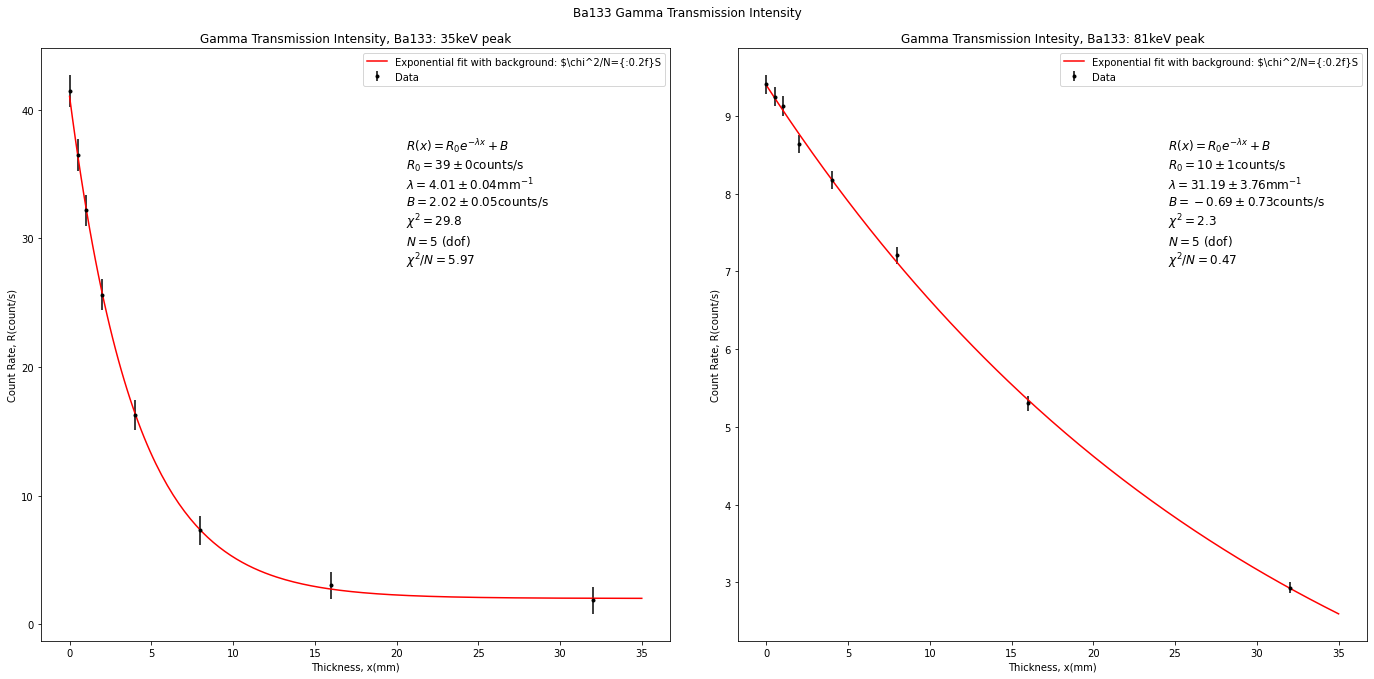

In [18]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
data_filename = "att_coef_data.txt"
using_colab = False

your_filename = "att_coef_data.txt"

x, t, G1, G2 = np.loadtxt(your_filename, unpack=True, skiprows=1)
print(x)
R1 = G1 / t
R2=G2/t
print(R1)
print(R2)
dR1=(R1*np.sqrt(G1))/G1
dR2=(R2*np.sqrt(G2))/G2
print(dR1)
print(dR2)

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err
def data_fit(p0,func,xvar, yvar, err,tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err),verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf,np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf,func,xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof



fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(1,2,1)
ay=fig.add_subplot(1,2,2)
t=np.linspace(0,50,550)

def expfunc_bg(p,x):
    return (p[0]*np.exp(-x/p[1]))+p[2]
guess_exp_bg=[100,500,-10]
pf_exp_bg,pferr_exp_bg,chisq_exp_bg,dof_exp_bg=data_fit(guess_exp_bg,expfunc_bg,x,R1,dR1)

textfit='$R(x)=R_{0}e^{-\lambda x}+B$\n'
textfit+='$R_{0}$'+'$={:.0f}\pm{:.0f}$counts/s\n'.format(pf_exp_bg[0],pferr_exp_bg[0])
textfit+='$\lambda={:.2f}\pm{:.2f}$mm$^{{-1}}$\n'.format(pf_exp_bg[1],pferr_exp_bg[1])
textfit+='$B={:.2f}\pm{:.2f}$counts/s\n'.format(pf_exp_bg[2],pferr_exp_bg[2])
textfit += '$\chi^2= {:.1f}$ \n'.format(chisq_exp_bg) 
textfit += '$N = {}$ (dof) \n'.format(dof_exp_bg) 
textfit += '$\chi^2/N = {:.2f}$'.format(chisq_exp_bg/dof_exp_bg) 

ax.text(0.58,0.85,textfit,transform=ax.transAxes,fontsize=12,verticalalignment='top')

ax.errorbar(x,R1,dR1+1,fmt='k.',label="Data")
t_cont=np.linspace(0,35,200)
ax.plot(t_cont,expfunc_bg(pf_exp_bg,t_cont),'r-',label="Exponential fit with background: $\chi^2/N={:0.2f}S")
ax.set_title("Gamma Transmission Intensity, Ba133: 35keV peak")
ax.set_xlabel("Thickness, x(mm)")
ax.set_ylabel("Count Rate, R(count/s)")
ax.legend()

guess_exp_bg=[100,500,-10]
pf_exp_bg,pferr_exp_bg,chisq_exp_bg,dof_exp_bg=data_fit(guess_exp_bg,expfunc_bg,x,R2,dR2)

textfit='$R(x)=R_{0}e^{-\lambda x}+B$\n'
textfit+='$R_{0}$'+'$={:.0f}\pm{:.0f}$counts/s\n'.format(pf_exp_bg[0],pferr_exp_bg[0])
textfit+='$\lambda={:.2f}\pm{:.2f}$mm$^{{-1}}$\n'.format(pf_exp_bg[1],pferr_exp_bg[1])
textfit+='$B={:.2f}\pm{:.2f}$counts/s\n'.format(pf_exp_bg[2],pferr_exp_bg[2])
textfit += '$\chi^2= {:.1f}$ \n'.format(chisq_exp_bg) 
textfit += '$N = {}$ (dof) \n'.format(dof_exp_bg) 
textfit += '$\chi^2/N = {:.2f}$'.format(chisq_exp_bg/dof_exp_bg) 

ay.text(1.79,0.85,textfit,transform=ax.transAxes,fontsize=12,verticalalignment='top')

ay.errorbar(x,R2,dR2,fmt='k.',label="Data")
t_cont=np.linspace(0,35,200)
ay.plot(t_cont,expfunc_bg(pf_exp_bg,t_cont),'r-',label="Exponential fit with background: $\chi^2/N={:0.2f}S")
ay.set_title("Gamma Transmission Intesity, Ba133: 81keV peak")
ay.set_xlabel("Thickness, x(mm)")
ay.set_ylabel("Count Rate, R(count/s)")
ay.legend()

fig.suptitle("Ba133 Gamma Transmission Intensity")
plt.tight_layout(pad=4)
plt.savefig('Ba133_Attenuation_Coefficient_Plots.pdf')